In [1]:
import xnemogcm
import xgcm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LogNorm
import gsw
import cmocean.cm as cmo
import xarray as xr
from skimage.morphology import dilation
from skimage.morphology import disk
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=12

This notebook is made to analyse the results from the Maud Rise configuration
Since the post-processing provides several variables in single files, first a combined data set needs to be created

In [2]:
rho=1026
cp=4000
rd=60
dt=86400


# Compare to M36

In [3]:
# path to the stored data
path=('../../MAUD_RISE_config/maud_v4/m36_ke2/sb/')

ds1=xr.open_mfdataset(path+'*_m36.nc',chunks={'t':60})
ds2=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_ke2/mld*_m36.nc',chunks={'t':60})
bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon.mean(dim='y')
bat.coords['nav_lat']=bat.nav_lat.mean(dim='x')
bat=bat.swap_dims({'x':'x_c','y':'y_c'})
mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')

# combine the datasets
ds=xr.merge((ds1,ds2,bat.bathy_meter,mask))
ds.coords['month']=ds.t.dt.month
ds.coords['year']=ds.t.dt.year
ds.coords['day']=ds.t.dt.day

del ds['nav_lon']
del ds['nav_lat']

ds36=ds

grid36 = xgcm.Grid(ds, coords={"X": {"center": "x_c", "right": "x_f"},"Y": {"center": "y_c", "right": "y_f"},"T":{"center":"t"},"Z":{"center":"z_c", "left":"z_f"}})
mean_bathy36 = ds.bathy_meter.rolling(x_c=39,center=True).mean().rolling(y_c=39,center=True).mean()
time_array36=np.array(ds.t,dtype=np.datetime64)


In [4]:
ds

<xarray.Dataset>
Dimensions:             (t: 4178, x_c: 879, y_c: 804)
Coordinates:
  * t                   (t) datetime64[ns] 2007-01-01T12:00:00 ... 2018-06-11...
  * x_c                 (x_c) int64 0 1 2 3 4 5 6 ... 873 874 875 876 877 878
  * y_c                 (y_c) int64 0 1 2 3 4 5 6 ... 798 799 800 801 802 803
    glamt               (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit               (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    month               (t) int64 1 1 1 1 1 1 1 1 1 1 1 ... 6 6 6 6 6 6 6 6 6 6
    year                (t) int64 2007 2007 2007 2007 ... 2018 2018 2018 2018
    day                 (t) int64 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11
Data variables: (12/25)
    S_at_Tmax_mean_ha   (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    S_at_Tmax_mean_tc   (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    dS_eddy_l1_tc       (t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    dS_eddy_l2_tc       (t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    dS_eddy_l3_tc       (t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    dS_l1_tc            (t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    ...                  ...
    mldr10_1            (t, y_c, x_c) float32 dask.array<chunksize=(31, 804, 879), meta=np.ndarray>
    bathy_meter         (y_c, x_c) float32 7.168 7.168 ... 5.03e+03 5.03e+03
    mask_ha             (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_ha_mod         (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tc             (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tr             (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>

# Components for the salt budget

In [5]:
#MAUD 36

surf_salt_tc36=((ds.sfdw_tc)/rho).load()

dS_l1_tc36=ds36.dS_l1_tc.load()
dS_eddy_l1_tc36=ds36.dS_eddy_l1_tc.load()
sf_up_200_tc36=ds36.sf_up_200_tc.load() 
eddy_sf_up_200_tc36=ds36.eddy_sf_up_200_tc.load() 
totsf_l1_tc36=(dS_l1_tc36+surf_salt_tc36+sf_up_200_tc36).rolling(t=2).mean().isel(t=slice(1,None,None)).load()
dsc_l1_tc36=(ds36.dsc_l1_tc).load()
#compute the residual
res_l1_tc36=(dsc_l1_tc36.diff(dim='t')/dt-totsf_l1_tc36).load()
  #in the volume
dS_tc36=ds36.dS_tc.load()
dS_eddy_tc36=(ds36.dS_eddy_l1_tc+ds36.dS_eddy_l2_tc+ds36.dS_eddy_l3_tc).load()
total_sflux_tc36=(dS_tc36+surf_salt_tc36).rolling(t=2).mean().isel(t=slice(1,None,None)).load()
dsc_dt_tc36=ds36.dsc_tc.load()

dS_l2_tc36=(ds36.dS_l2_tc).load()
sf_up_1000_tc36=(ds36.sf_up_1000_tc).load() 
dS_eddy_l2_tc36=(ds36.dS_eddy_l2_tc).load()
eddy_sf_up_1000_tc36=(ds36.eddy_sf_up_1000_tc).load() 
totsf_l2_tc36=(dS_l2_tc36-sf_up_200_tc36+sf_up_1000_tc36).rolling(t=2).mean().isel(t=slice(1,None,None)).load()
dsc_l2_tc36=(ds36.dsc_l2_tc).load()
#compute the residual
res_l2_tc36=(dsc_l2_tc36.diff(dim='t')/dt-totsf_l2_tc36).load()

# the heat in the depth below 1 000m  is controlled by the lateral changes and fluxes through the 1000m depth
dS_l3_tc36=ds36.dS_l3_tc.load()
dS_eddy_l3_tc36=ds36.dS_eddy_l3_tc.load()
totsf_l3_tc36=(dS_l3_tc36-sf_up_1000_tc36).rolling(t=2).mean().isel(t=slice(1,None,None)).load()
dsc_l3_tc36=(ds36.dsc_l3_tc).load()
#compute the residual
res_l3_tc36=(dsc_l3_tc36.diff(dim='t')/dt-totsf_l3_tc36).load()

<ipython-input-36-a268adb7e3b0>:74: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


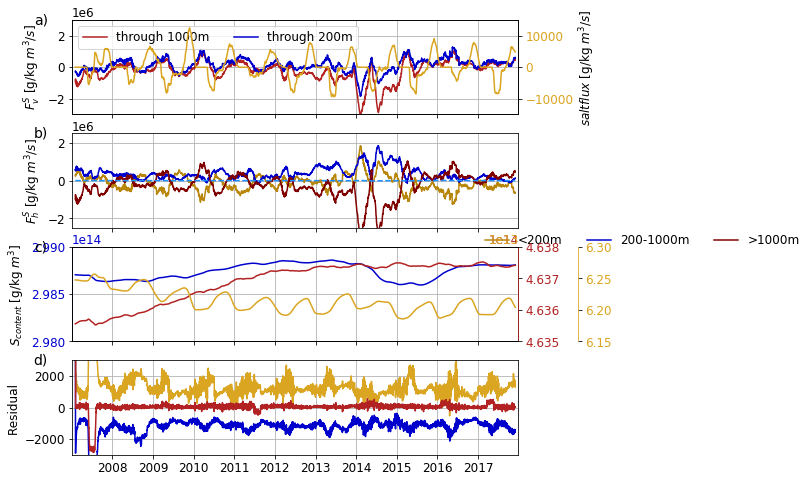

In [36]:
# Figure 9 of the manuscript

rd=60
fig,axes=plt.subplots(4,1,figsize=(8,8),sharex=True)
ax=axes[0]
sf_up_1000_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='firebrick',linestyle='-',label='through 1000m')
(sf_up_200_tc36).rolling(t=rd,center=True).mean().plot(ax=ax,color='mediumblue',linestyle='-',label='through 200m')
ax.tick_params(axis='y',labelcolor='k')
plt.text(-0.07, 1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
ax.set_ylim(-3e6,3e6)

ax2=ax.twinx()
surf_salt_tc36.rolling(t=rd,center=True).mean().plot(ax=ax2,color='goldenrod',linestyle='-',label='surface')
ax2.set_ylabel('$salt flux$ [g/kg $m^3/s$]')
ax2.set_title('')
ax2.tick_params(axis='y',labelcolor='goldenrod')
ax2.set_ylim(-1.5e4,1.5e4)
ax.legend(ncol=3)

ax=axes[1]
dS_l1_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='darkgoldenrod',linestyle='-',label='<200m')
dS_l2_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='mediumblue',linestyle='-',label='200-1000m')
dS_l3_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='maroon',linestyle='-',label='>1000m')
dS_eddy_l2_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='dodgerblue',linestyle='--')
plt.text(-0.07, 1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
ax.set_ylim(-2.5e6,2.5e6)
ax.legend(ncol=3,frameon=False,bbox_to_anchor=(0.9,-.15,.0,.2))#,frameon=False)#,bbox_to_anchor=(0.6,1.05,.10,.2))

ax=axes[2]
#plt.subplots_adjust(right=0.75)
dsc_l2_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='mediumblue',linestyle='-',label='200-1000m')
ax.set_ylim(2.98e14,2.99e14)
ax.tick_params(axis='y',labelcolor='mediumblue')
ax.spines['left'].set_color('mediumblue')
ax2=ax.twinx()
dsc_l3_tc36.rolling(t=rd,center=True).mean().plot(ax=ax2,color='firebrick',linestyle='-',label='>1000m')#
ax2.set_ylabel('')
ax2.tick_params(axis='y',labelcolor='firebrick')
ax2.spines['right'].set_color('firebrick')
ax2.set_ylim(4.635e14,4.638e14)
par2 = ax.twinx()
par2.spines['right'].set_position(('outward', 60))
par2.spines['right'].set_color('goldenrod')
dsc_l1_tc36.rolling(t=rd,center=True).mean().plot(ax=par2,color='goldenrod',linestyle='-',label='<200m')
par2.set_ylabel('')
par2.tick_params(axis='y',labelcolor='goldenrod')
par2.set_ylim(6.15e13,6.30e13)
plt.text(-0.07, 1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[3]
res_l1_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='goldenrod',linestyle='-',label='<200m')
res_l2_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='mediumblue',linestyle='-',label='200-1000m')
res_l3_tc36.rolling(t=rd,center=True).mean().plot(ax=ax,color='firebrick',linestyle='-',label='>1000m')#
ax.set_ylim(-3e3,3e3)
#(-1*ds36.mldr10_1.where(ds36.mask_tc==1).max(dim={'x_c','y_c'})).plot(ax=ax,color='k')
#ax.hlines(y=-200,xmin=time_array36[0],xmax=time_array36[-1],color='mediumblue')
#ax.hlines(y=-1000,xmin=time_array36[0],xmax=time_array36[-1],color='firebrick')
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
plt.text(-0.07, 1, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')


for i in range(0,4):
    axes[i].grid() 
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title('')
    axes[i].set_xlim((time_array36[1],time_array36[-163]))


axes[0].set_ylabel('$F^{S}_{v}$ [g/kg $m^3/s$]')
axes[1].set_ylabel('$F^{S}_{h}$ [g/kg $m^3/s$]')
axes[2].set_ylabel('$S_{content}$ [g/kg $m^3$]')
axes[3].set_ylabel('Residual ')
plt.tight_layout()
#plt.savefig('../figures/Salt_budget_all.jpg',dpi=300)

In [6]:
ds

<xarray.Dataset>
Dimensions:             (t: 4178, x_c: 879, y_c: 804)
Coordinates:
  * t                   (t) datetime64[ns] 2007-01-01T12:00:00 ... 2018-06-11...
  * x_c                 (x_c) int64 0 1 2 3 4 5 6 ... 873 874 875 876 877 878
  * y_c                 (y_c) int64 0 1 2 3 4 5 6 ... 798 799 800 801 802 803
    glamt               (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit               (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    month               (t) int64 1 1 1 1 1 1 1 1 1 1 1 ... 6 6 6 6 6 6 6 6 6 6
    year                (t) int64 2007 2007 2007 2007 ... 2018 2018 2018 2018
    day                 (t) int64 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11
Data variables: (12/25)
    S_at_Tmax_mean_ha   (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    S_at_Tmax_mean_tc   (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    dS_eddy_l1_tc       (t) float64 1.766e+04 1.709e+04 1.451e+04 ... nan nan
    dS_eddy_l2_tc       (t) float64 -2.621e+03 2.327e+03 -904.8 ... nan nan nan
    dS_eddy_l3_tc       (t) float64 5.301e+03 4.983e+03 4.55e+03 ... nan nan nan
    dS_l1_tc            (t) float64 1.498e+06 2.417e+06 -9.526e+04 ... nan nan
    ...                  ...
    mldr10_1            (t, y_c, x_c) float32 dask.array<chunksize=(31, 804, 879), meta=np.ndarray>
    bathy_meter         (y_c, x_c) float32 7.168 7.168 ... 5.03e+03 5.03e+03
    mask_ha             (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_ha_mod         (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tc             (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tr             (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>

In [9]:
dS_l2_tc36=ds36.dS_l2_tc.load()
dS_eddy_l2_tc36=ds36.dS_eddy_l2_tc.load()
dS_mean_l2_tc36=ds36.dS_mean_l2_tc.load()

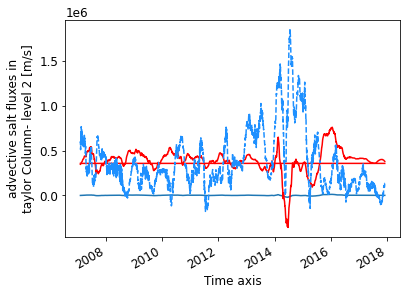

In [13]:
(dS_eddy_l2_tc36).rolling(t=rd,center=True).mean().plot()
(dS_mean_l2_tc36).rolling(t=rd,center=True).mean().plot(color='r')
(dS_eddy_l2_tc36*34+dS_mean_l2_tc36).rolling(t=rd,center=True).mean().plot(color='r')
(dS_l2_tc36).rolling(t=rd,center=True).mean().plot(color='dodgerblue',linestyle='--')

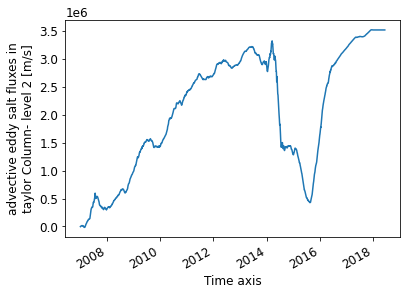

In [39]:
dS_eddy_l1_tc36.cumsum(dim='t').plot()
dS_eddy_l2_tc36.cumsum(dim='t').plot()
dS_eddy_l3_tc36.cumsum(dim='t').plot()

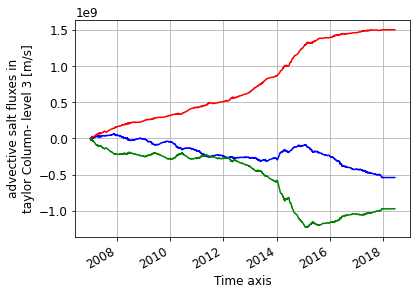

In [43]:
(dS_l1_tc36).cumsum(dim='t').plot(color='b')
(dS_l2_tc36).cumsum(dim='t').plot(color='r')
(dS_l3_tc36).cumsum(dim='t').plot(color='g')
plt.grid()

Text(0, 0.5, 'time integrated eddy salt flux')

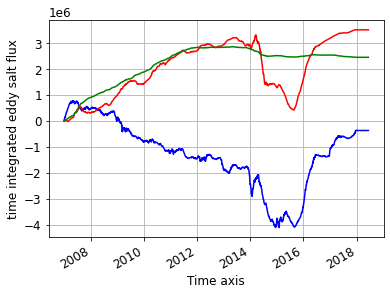

In [45]:
(dS_eddy_l1_tc36).cumsum(dim='t').plot(color='b')
(dS_eddy_l2_tc36).cumsum(dim='t').plot(color='r')
(dS_eddy_l3_tc36).cumsum(dim='t').plot(color='g')
plt.grid()
plt.ylabel('time integrated eddy salt flux')